# Benötigten Bibliotheken

In [1]:
import time
import os
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

# Datensatz vorbereiten

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'datasets/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: datasets/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: datasets/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [4]:
image_datasets["train"]

Dataset ImageFolder
    Number of datapoints: 244
    Root location: datasets/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x738299f08b60>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x738189dbe240>}

In [7]:
len(dataloaders["train"])

61

In [8]:
244 / 4

61.0

In [9]:
dataset_sizes

{'train': 244, 'val': 153}

In [10]:
class_names

['ants', 'bees']

In [11]:
device

device(type='cuda', index=0)

# Ein paar Bilder schon mal anzeigen

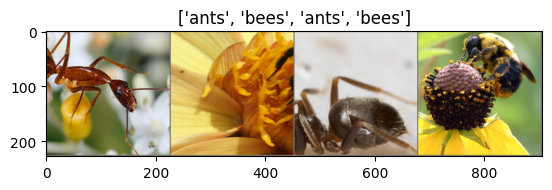

In [24]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
dataloaders['train']

In [17]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [18]:
classes

tensor([0, 1, 0, 0])

In [20]:
out.shape

torch.Size([3, 228, 906])

In [21]:
4*224

896

In [22]:
out

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  1.1187,  ..., -0.6281,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.1768,  ...,  1.2385,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.9405,  ..., -0.6877,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.1001,  ...,  1.2556,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

# Trainingsfunktion definieren

In [25]:
'-' * 10

'----------'

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

# Funktion, um Modellprädiktionen zu visualisieren

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [30]:
class_names[1]

'bees'

# CNN vorbereiten

In [31]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/juebrauer/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|████████████████████████████████████████████████████| 44.7M/44.7M [00:06<00:00, 7.34MB/s]


In [32]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Modell trainieren

In [33]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5679 Acc: 0.7090
val Loss: 0.5866 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.4639 Acc: 0.8033
val Loss: 0.1816 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4979 Acc: 0.8074
val Loss: 0.5314 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.5702 Acc: 0.7664
val Loss: 0.2915 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.3687 Acc: 0.8525
val Loss: 0.2597 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.5584 Acc: 0.7828
val Loss: 0.4532 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.8893 Acc: 0.7336
val Loss: 0.6470 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.5597 Acc: 0.8320
val Loss: 0.2061 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4294 Acc: 0.8525
val Loss: 0.1714 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3700 Acc: 0.8770
val Loss: 0.1711 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.5229 Acc: 0.8115
val Loss: 0.1942 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2846 Acc: 0.8893
val Loss: 0.1740 Acc: 0.9346

Ep

# Visualisieren einiger Prädiktionen des trainierten Modells

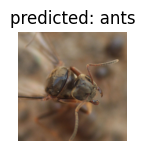

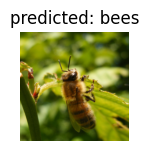

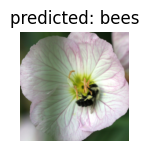

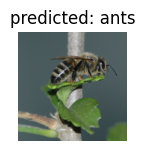

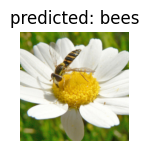

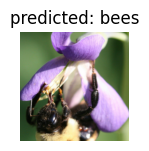

In [35]:
visualize_model(model_ft)

# Das CNN mit eingefrorenen Gewichten verwenden

In [39]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [38]:
model_conv.fc.in_features

Linear(in_features=512, out_features=1000, bias=True)

In [40]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5296 Acc: 0.7377
val Loss: 0.2060 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.7337 Acc: 0.7008
val Loss: 0.1542 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.8499 Acc: 0.6885
val Loss: 0.2101 Acc: 0.9346

Epoch 3/24
----------
train Loss: 0.5883 Acc: 0.7951
val Loss: 0.4852 Acc: 0.8235

Epoch 4/24
----------
train Loss: 0.4730 Acc: 0.8156
val Loss: 0.2826 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4176 Acc: 0.8402
val Loss: 0.1696 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4575 Acc: 0.8320
val Loss: 0.2147 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4303 Acc: 0.8156
val Loss: 0.1931 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4137 Acc: 0.8197
val Loss: 0.1803 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.4469 Acc: 0.8115
val Loss: 0.1812 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3262 Acc: 0.8566
val Loss: 0.1897 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2980 Acc: 0.8689
val Loss: 0.1950 Acc: 0.9412

Ep

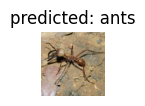

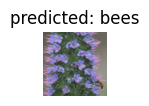

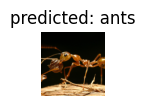

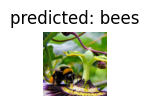

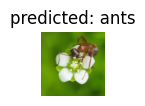

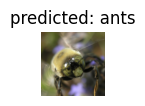

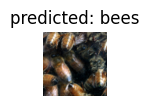

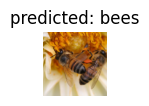

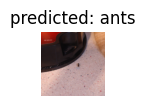

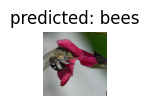

In [42]:
visualize_model(model_conv, num_images=10)

plt.ioff()
plt.show()